In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mne

from sklearn.decomposition import PCA, FastICA

#### Importing data from subject 1

In [2]:
raw_fname = 'rawdata/bidsexport/sub-001/ses-02/eeg/sub-001_ses-02_task-meditation_eeg.bdf'

raw = mne.io.read_raw_bdf(raw_fname, preload=True)
raw.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 
                   'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])

Extracting EDF parameters from /Users/yuyang.zhong/eeg/rawdata/bidsexport/sub-001/ses-02/eeg/sub-001_ses-02_task-meditation_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 695551  =      0.000 ...  2716.996 secs...


<RawEDF  |  sub-001_ses-02_task-meditation_eeg.bdf, n_channels x n_times : 65 x 695552 (2717.0 sec), ~345.1 MB, data loaded>

#### Setting Montage Manually

In [1]:
raw.set_montage('biosemi64alpha');

NameError: name 'mne' is not defined

#### Printing subject 1 meta data

In [4]:
print(raw)
print(raw.info)

<RawEDF  |  sub-001_ses-02_task-meditation_eeg.bdf, n_channels x n_times : 65 x 695552 (2717.0 sec), ~345.1 MB, data loaded>
<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | A1, A2, A3, A4, A5, A6, A7, A8, A9, ...
    chs : list | 65 items (EEG: 64, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 67 items (3 Cardinal, 64 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 52.0 Hz
    meas_date : tuple | 2014-04-04 20:30:06 GMT
    nchan : int | 65
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 256.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info

#### Showing power spectral density (PSD) & raw sensor traces

Effective window size : 8.000 (s)


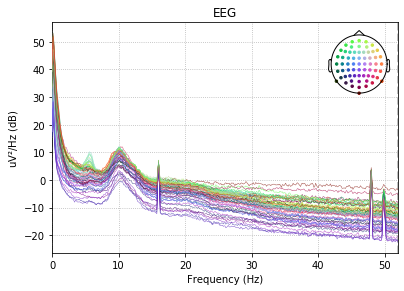

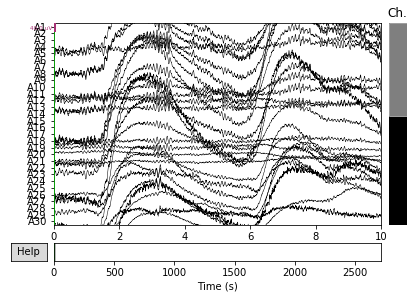

In [5]:
raw.plot_psd(fmax=52)
raw.plot(duration=10, n_channels=30);

#### Looking at events

In [6]:
events = mne.find_events(raw, stim_channel='Status')
print(events[:5])

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
101 events found
Event IDs: [  2   4 128]
[[27119     0   128]
 [27894     0     4]
 [29032     0     2]
 [34715     0   128]
 [35523     0     2]]


In [7]:
event_dict = {'Response 1 (this may be a response to question 1, 2 or 3)': 2,
                 'Response 2 (this may be a response to question 1, 2 or 3)': 4,
                 'First question onset (most important marker)': 128}

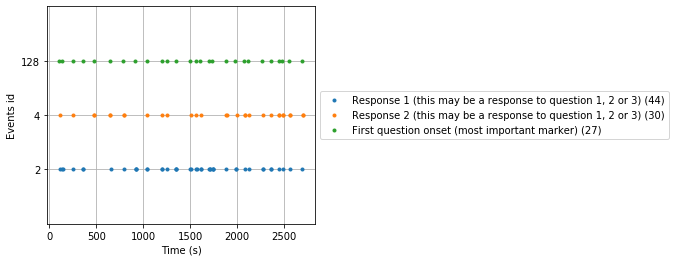

In [8]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

#### Epoching continuous data

In [9]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5, preload=True)

101 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 101 events and 180 original time points ...
0 bad epochs dropped


In [10]:
conds_we_care_about = ['Response 1 (this may be a response to question 1, 2 or 3)',
                       'Response 2 (this may be a response to question 1, 2 or 3)',
                      'First question onset (most important marker)']
epochs.equalize_event_counts(conds_we_care_about)

Dropped 20 epochs


(<Epochs  |   81 events (all good), -0.199219 - 0.5 sec, baseline [None, 0], ~7.4 MB, data loaded,
  'First question onset (most important marker)': 27
  'Response 1 (this may be a response to question 1, 2 or 3)': 27
  'Response 2 (this may be a response to question 1, 2 or 3)': 27>,
 array([  5,  25,  26,  30,  34,  40,  41,  45,  49,  53,  56,  57,  60,
         61,  68,  79,  83,  92,  96, 100]))

27 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


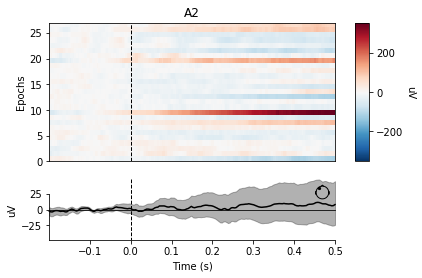

[<Figure size 432x288 with 4 Axes>]

In [11]:
r1_epochs = epochs['Response 1 (this may be a response to question 1, 2 or 3)']
r2_epochs = epochs['Response 2 (this may be a response to question 1, 2 or 3)']
onset_epochs = epochs['First question onset (most important marker)']
r1_epochs.plot_image(picks=['A2'])

#### Time frequency analysis

No baseline correction applied


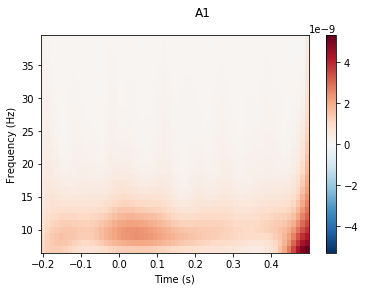

In [12]:
frequencies = np.arange(7, 40, 1)
power = mne.time_frequency.tfr_morlet(r1_epochs, n_cycles=3, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['A1']);

#### evoked response

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


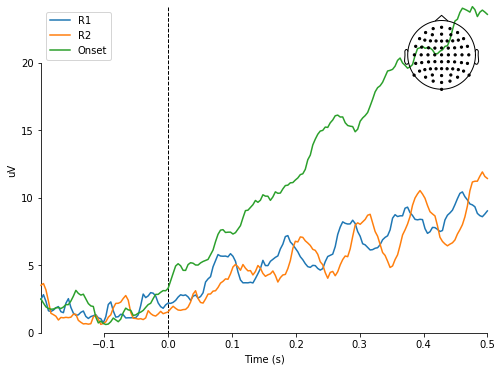

[<Figure size 576x432 with 2 Axes>]

In [13]:
r1_evoked = r1_epochs.average()
r2_evoked = r2_epochs.average()
onset_evoked = onset_epochs.average()

mne.viz.plot_compare_evokeds(dict(R1=r1_evoked, R2=r2_evoked, Onset=onset_evoked),
                             legend='upper left', show_sensors='upper right')

In [14]:
r1_evoked

<Evoked  |  'Response 1 (this may be a response to question 1, 2 or 3)' (average, N=27), [-0.19922, 0.5] sec, 64 ch, ~270 kB>

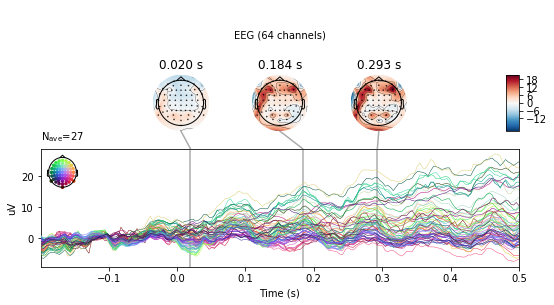

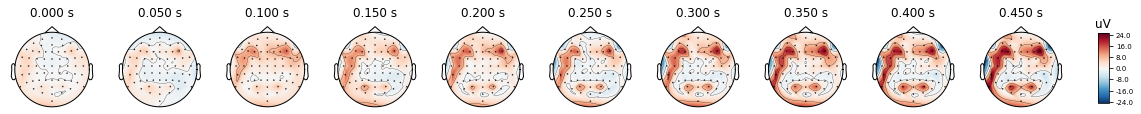

In [15]:
r1_evoked.plot_joint()
r1_evoked.plot_topomap(times=np.arange(0,0.5,0.05));

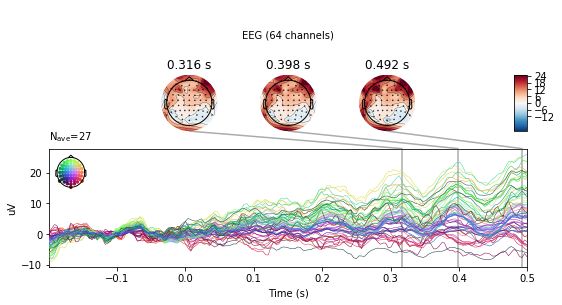

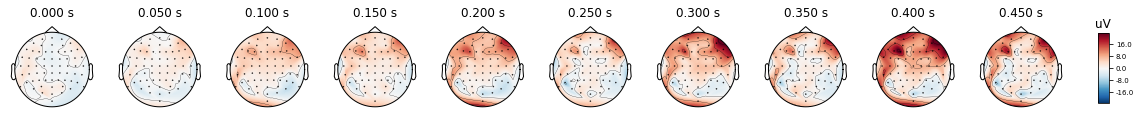

In [16]:
r2_evoked.plot_joint()
r2_evoked.plot_topomap(times=np.arange(0,0.5,0.05));

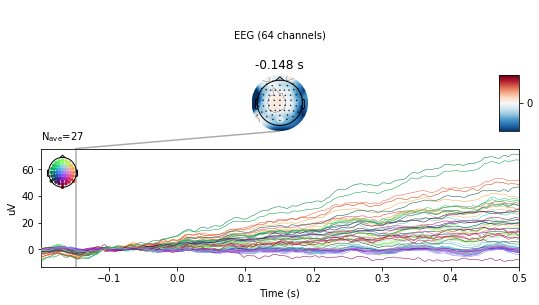

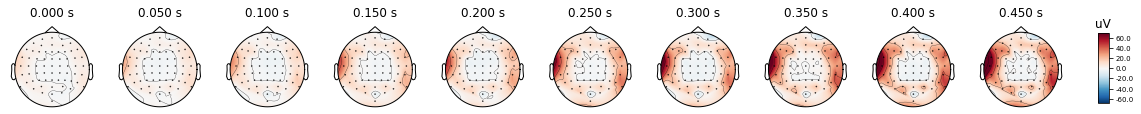

In [17]:
onset_evoked.plot_joint()
onset_evoked.plot_topomap(times=np.arange(0,0.5,0.05));